This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/main/pipeline-edge-publish/edge-unet-brain-segmentation-demonstration).

## Wallaroo Inference Server:  U-Net for Brain Segmentation

This notebook is used in conjunction with the [Wallaroo Inference Server Free Edition](https://docs.wallaroo.ai/wallaroo-inferencing-server/) for U-Net for Brain Segmentation.  This provides a free Wallaroo license for performing inferences through the [U-Net for Brain Segmentation](https://github.com/mateuszbuda/brain-segmentation-pytorch/tree/master) model.  The U-Net model is trained to detect lower-grade gliomas.

This tutorial demonstrates how to:

* Convert sample images of brain scans to tensor values and perform inferences through the [Wallaroo Inference Server Free Edition](https://docs.wallaroo.ai/wallaroo-inferencing-server/) for U-Net for Brain Segmentation

### Prerequisites

* A deployed Wallaroo Inference Server Free Edition with one of the following options:
  * **Wallaroo.AI U-Net for Brain MRI Segmentation - x64**
* Access via port 8080 to the Wallaroo Inference Server Free Edition.

## U-Net for Brain MRI Segmentation Model Schemas

### Inputs
input_schema = pa.schema([
    pa.field('input', pa.list_(
        pa.list_(
            pa.list_(
                pa.float32(),
                list_size=256
            ),
            list_size=256
        ),
        list_size=3
    )),
])

output_schema = pa.schema([
    pa.field('output', pa.list_(
        pa.list_(
            pa.list_(
                pa.float32(),
                list_size=256
            ),
            list_size=256
        ),
        list_size=1
    )),
])


The U-Net for Brain MRI Segmentation Model takes the following inputs.

| Field | Type | Description |
|---|---|---|
| `input` | List(Float) | Tensor in the shape (n, 3, 256, 256) float.  This is the normalized pixel values of the 640x480 color image.

### Outputs

| Field | Type | Description |
|---|---|---|
| `output` | Variable length *List[Float]* | A flattened numpy array of detected objects.  When reshaped into a `(1, 256, 256)` returns where the bounding for a detected glioma. |

In [1]:
import wallaroo
from wallaroo.pipeline   import Pipeline
from wallaroo.deployment_config import DeploymentConfigBuilder
from wallaroo.framework import Framework

# used to convert the Image into a numpy array
from PIL import Image
from torchvision import transforms

import pyarrow as pa
import numpy as np
import pandas as pd

import requests

# used to display dataframe information without truncating
from IPython.display import display
pd.set_option('display.max_colwidth', None)


### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

The option `request_timeout` provides additional time for the Wallaroo model upload process to complete.

In [ ]:
wl = wallaroo.Client()

wl = wallaroo.Client()

wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace names must be unique.  The following helper function will either create a new workspace, or retrieve an existing one with the same name.  Verify that a pre-existing workspace has been shared with the targeted user.

Set the variables `workspace_name` to ensure a unique workspace name if required.

The workspace will then be set as the Current Workspace.  Model uploads and pipeline creation through the SDK are set in the current workspace.

* References
  * [Wallaroo SDK Essentials Guide: Workspace Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/)

In [3]:
def get_workspace(name, client):
    workspace = None
    for ws in client.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = client.create_workspace(name)
    return workspace

workspace_name = "unet-detection-run-anywhere-demonstration"
model_name = "pt-unet"
model_file_name = './models/unet.pt'
pipeline_name = "pt-unet"

workspace = get_workspace(workspace_name, wl)
wl.set_current_workspace(workspace)

{'name': 'unet-detection-run-anywhere-demonstration', 'id': 8, 'archived': False, 'created_by': '784e4c99-ee08-4aab-9eaa-0d8ad8e1af53', 'created_at': '2024-02-12T18:37:09.788501+00:00', 'models': [{'name': 'pt-unet', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 2, 12, 18, 37, 14, 879178, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 2, 12, 18, 37, 14, 879178, tzinfo=tzutc())}], 'pipelines': [{'name': 'pt-unet', 'create_time': datetime.datetime(2024, 2, 12, 18, 41, 46, 924275, tzinfo=tzutc()), 'definition': '[]'}]}

### Upload Model

The model is uploaded as a PyTorch model.  This requires the input and output schemas for the model specified in Apache Arrow Schema format.

* References
  * [Wallaroo SDK Essentials Guide: Model Uploads and Registrations: PyTorch](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/wallaroo-sdk-model-upload-pytorch/)

In [4]:
import pyarrow as pa

input_schema = pa.schema([
    pa.field('input', pa.list_(
        pa.list_(
            pa.list_(
                pa.float32(),
                list_size=256
            ),
            list_size=256
        ),
        list_size=3
    )),
])

output_schema = pa.schema([
    pa.field('output', pa.list_(
        pa.list_(
            pa.list_(
                pa.float32(),
                list_size=256
            ),
            list_size=256
        ),
        list_size=1
    )),
])


In [8]:
models = workspace.models()
model01 = models[0]
model = model01.versions()[-1]
model

{'name': 'pt-unet', 'version': '09f27ed8-b9ca-46de-a416-e78b4cbe2ded', 'file_name': 'unet.pt', 'image_path': 'proxy.replicated.com/proxy/wallaroo/ghcr.io/wallaroolabs/mlflow-deploy:v2023.4.1-4514', 'arch': None, 'accel': None, 'last_update_time': datetime.datetime(2024, 2, 12, 18, 41, 44, 821524, tzinfo=tzutc())}

In [48]:
modelpath = 'models/unet.pt'

model = wl.upload_model(model_name, 
                        model_file_name, 
                        framework=Framework.PYTORCH, 
                        input_schema=input_schema, 
                        output_schema=output_schema)
model

Waiting for model loading - this will take up to 10.0min.
Model is pending loading to a native runtime......
Model is pending loading to a container runtime...
Model is attempting loading to a container runtime........................................................successful

Ready


{'name': 'pt-unet', 'version': '5a0f70fc-e33b-487c-80c9-24e23e5621b5', 'file_name': 'unet.pt', 'image_path': 'proxy.replicated.com/proxy/wallaroo/ghcr.io/wallaroolabs/mlflow-deploy:v2023.4.0-4329', 'arch': None, 'last_update_time': datetime.datetime(2024, 1, 18, 18, 37, 44, 811197, tzinfo=tzutc())}

In [9]:
model.config().runtime()

'flight'

### Deploy Pipeline

We create the pipeline with the `wallaroo.client.build_pipeline` method, and assign our model as a model pipeline step.  Once complete, we will deploy the pipeline to allocate resources from the Kuberntes cluster hosting the Wallaroo Ops to the pipeline.

In [10]:
pipeline = wl.build_pipeline(pipeline_name)
pipeline.add_model_step(model)

{'name': 'pt-unet', 'create_time': datetime.datetime(2024, 2, 12, 18, 41, 46, 924275, tzinfo=tzutc()), 'definition': "[{'ModelInference': {'models': [{'name': 'pt-unet', 'version': '09f27ed8-b9ca-46de-a416-e78b4cbe2ded', 'sha': 'dfcd4b092e05564c36d28f1dfa7293f4233a384d81fe345c568b6bb68cafb0c8'}]}}]"}

Next we configure the hardware we want to use for deployment. If we plan on eventually deploying to edge, this is a good way to simulate edge hardware conditions.

The pipeline is then deployed with our deployment configuration, which allocates cluter resources to the pipeline.

* References
  * [Wallaroo SDK Essentials Guide: Pipeline Deployment Configuration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-deployment-config/)

In [11]:
deployment_config = DeploymentConfigBuilder() \
    .cpus(0.25).memory('1Gi') \
    .build()
pipeline.deploy(deployment_config=deployment_config)
pipeline.status()

{'status': 'Running',
 'details': [],
 'engines': [{'ip': '10.100.1.132',
   'name': 'engine-6f8dc97cdf-r6tm4',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'pt-unet',
      'status': 'Running'}]},
   'model_statuses': {'models': [{'name': 'pt-unet',
      'version': '09f27ed8-b9ca-46de-a416-e78b4cbe2ded',
      'sha': 'dfcd4b092e05564c36d28f1dfa7293f4233a384d81fe345c568b6bb68cafb0c8',
      'status': 'Running'}]}}],
 'engine_lbs': [{'ip': '10.100.0.135',
   'name': 'engine-lb-dcd9c8cd7-dw5vh',
   'status': 'Running',
   'reason': None,
   'details': []}],
 'sidekicks': [{'ip': '10.100.0.136',
   'name': 'engine-sidekick-pt-unet-5-5656c776f7-x4qq6',
   'status': 'Running',
   'reason': None,
   'details': [],
   'statuses': '\n'}]}

### Test Inference

We will perform a test inference by converting the file `TCGA_CS_4944.png` into a numpy array, and setting that as a row in a DataFrame for our inference request.

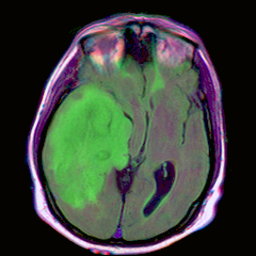

(1, 3, 256, 256)

In [17]:

input_image = Image.open("./data/TCGA_CS_4944.png")
display(input_image)

# preprocess
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

nimage = input_batch.detach().numpy()
nimage.shape

In [18]:
nimage = input_tensor.detach().numpy()

input_data = {
        "input": [nimage]
}
dataframe = pd.DataFrame(input_data)

We can now perform an inference in two ways:

* Wallaroo SDK:  The method `wallaroo.pipeline.infer` accepts a DataFrame or Apache Arrow table and returns an inference result.
* Wallaroo Pipline Inference URL:  Deployed pipelines provide an inference URL that accepts a DataFrame or Apache Arrow table through an API call.

For this demonstration and to save space in the notebook, only the first few elements are shown.

* References
  * [Wallaroo SDK Essentials Guide: Inference Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-inferences/)
  * [Wallaroo MLOps API Essentials Guide: Inference Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-api-guide/wallaroo-mlops-api-essential-guide/wallaroo-mlops-api-essential-guide-inferences/)

In [19]:
# inference via the Wallaroo SDK
result = pipeline.infer(dataframe)
# display(result)
result['out.output'][0][0][0][0:5]

[1.471237e-05, 1.45947615e-05, 1.3948585e-05, 1.3920239e-05, 1.453936e-05]

In [84]:
# inference via the Wallaroo Pipeline Inference URL

headers = wl.auth.auth_header()

headers['Content-Type'] = 'application/json; format=pandas-records'

deploy_url = pipeline._deployment._url()

response = requests.post(
                    deploy_url, 
                    headers=headers, 
                    data=dataframe.to_json(orient="records")
                )

display(pd.DataFrame(response.json()).loc[0, 'out']['output'][0][0][0:5])

[1.471237e-05, 1.4594775e-05, 1.3948557e-05, 1.3920214e-05, 1.4539372e-05]

### Undeploy the Pipeline

With the inference tests complete, we can undeploy the pipeline and return the resources back to the cluster.

In [20]:
pipeline.undeploy()

{'name': 'pt-unet', 'create_time': datetime.datetime(2024, 2, 12, 18, 41, 46, 924275, tzinfo=tzutc()), 'definition': "[{'ModelInference': {'models': [{'name': 'pt-unet', 'version': '09f27ed8-b9ca-46de-a416-e78b4cbe2ded', 'sha': 'dfcd4b092e05564c36d28f1dfa7293f4233a384d81fe345c568b6bb68cafb0c8'}]}}]"}

### Publish the Pipeline for Edge Deployment

It worked! For a demo, we'll take working once as "tested". So now that we've tested our pipeline, we are ready to publish it for edge deployment.

Publishing it means assembling all of the configuration files and model assets and pushing them to an Open Container Initiative (OCI) repository set in the Wallaroo instance as the Edge Registry service.  DevOps engineers then retrieve that image and deploy it through Docker, Kubernetes, or similar deployments.

See [Edge Deployment Registry Guide](https://staging.docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/) for details on adding an OCI Registry Service to Wallaroo as the Edge Deployment Registry.

This is done through the SDK command `wallaroo.pipeline.publish(deployment_config)` which has the following parameters and returns.

#### Publish a Pipeline Parameters

The `publish` method takes the following parameters.  The containerized pipeline will be pushed to the Edge registry service with the model, pipeline configurations, and other artifacts needed to deploy the pipeline.

| Parameter | Type | Description |
|---|---|---|
| `deployment_config` | `wallaroo.deployment_config.DeploymentConfig` (*Optional*) | Sets the pipeline deployment configuration.  For example:    For more information on pipeline deployment configuration, see the [Wallaroo SDK Essentials Guide: Pipeline Deployment Configuration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-deployment-config/).

#### Publish a Pipeline Returns

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline version id | integer | Numerical Wallaroo id of the pipeline version published. |
| status | string | The status of the pipeline publication.  Values include:  <ul><li>PendingPublish: The pipeline publication is about to be uploaded or is in the process of being uploaded.</li><li>Published:  The pipeline is published and ready for use.</li></ul> |
| Engine URL | string | The URL of the published pipeline engine in the edge registry. |
| Pipeline URL | string | The URL of the published pipeline in the edge registry. |
| Helm Chart URL | string | The URL of the helm chart for the published pipeline in the edge registry. |
| Helm Chart Reference | string | The help chart reference. |
| Helm Chart Version | string | The version of the Helm Chart of the published pipeline.  This is also used as the Docker tag. |
| Engine Config | `wallaroo.deployment_config.DeploymentConfig` | The pipeline configuration included with the published pipeline. |
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

### Publish Example

We will now publish the pipeline to our Edge Deployment Registry with the `pipeline.publish(deployment_config)` command. 

In [57]:
# edge deployment

pub = pipeline.publish()
pub

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is Publishing..................................Published.


PipelinePublish(created_at=datetime.datetime(2024, 1, 18, 18, 39, 59, 294688, tzinfo=tzutc()), docker_run_variables={}, engine_config={'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '3Gi'}, 'requests': {'cpu': 4.0, 'memory': '3Gi'}, 'arch': 'x86', 'gpu': False}}, 'engineAux': {}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 0.2, 'memory': '512Mi'}, 'arch': 'x86', 'gpu': False}}}, id=15, pipeline_version_id=108, status='Published', updated_at=datetime.datetime(2024, 1, 18, 18, 39, 59, 294688, tzinfo=tzutc()), user_images=[], created_by='2ea98261-c84d-44b1-ac86-ff932e65b285', engine_url='us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.0-4329', error=None, helm={'reference': 'us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/charts@sha256:e899a6968f68f0f24c07c85cd5ec9efea3e6a20891da5aeb2d243cb9a64bc9ac', 'values': {}, 'chart': 'us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/charts/pt-unet', 'version': '0.0.1-309e703c-28e4-4603-9caf-1e488afc57ae'}, pipeline_url='us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/pipelines/pt-unet:309e703c-28e4-4603-9caf-1e488afc57ae', pipeline_version_name='309e703c-28e4-4603-9caf-1e488afc57ae', additional_properties={})

## DevOps - Pipeline Edge Deployment

Once a pipeline is deployed to the Edge Registry service, it can be deployed in environments such as Docker, Kubernetes, or similar container running services by a DevOps engineer.

### Docker Deployment

First, the DevOps engineer must authenticate to the same OCI Registry service used for the Wallaroo Edge Deployment registry.

For more details, check with the documentation on your artifact service.  The following are provided for the three major cloud services:

* [Set up authentication for Docker](https://cloud.google.com/artifact-registry/docs/docker/authentication)
* [Authenticate with an Azure container registry](https://learn.microsoft.com/en-us/azure/container-registry/container-registry-authentication?tabs=azure-cli)
* [Authenticating Amazon ECR Repositories for Docker CLI with Credential Helper](https://aws.amazon.com/blogs/compute/authenticating-amazon-ecr-repositories-for-docker-cli-with-credential-helper/)

For the deployment, the engine URL is specified with the following environmental variables:

* `DEBUG` (true|false): Whether to include debug output.
* `OCI_REGISTRY`: The URL of the registry service.
* `CONFIG_CPUS`: The number of CPUs to use.
* `OCI_USERNAME`: The edge registry username.
* `OCI_PASSWORD`:  The edge registry password or token.
* `PIPELINE_URL`: The published pipeline URL.

#### Docker Deployment Example

Using our sample environment, here's sample deployment using Docker.

For `docker run` commands, the persistent volume for storing session data is stored with `-v ./data:/persist`.  Updated as required for your deployments.

In [58]:
# create docker run 

docker_command = f'''
docker run -p 8080:8080 \\
    -v ./data:/persist \\
    -e DEBUG=true \\
    -e OCI_REGISTRY=$REGISTRYURL \\
    -e CONFIG_CPUS=6 \\
    -e OCI_USERNAME=$REGISTRYUSERNAME \\
    -e OCI_PASSWORD=$REGISTRYPASSWORD \\
    -e PIPELINE_URL={pub.pipeline_url} \\
    {pub.engine_url}
'''

print(docker_command)


docker run -p 8080:8080 \
    -v ./data:/persist \
    -e DEBUG=true \
    -e OCI_REGISTRY=$REGISTRYURL \
    -e CONFIG_CPUS=6 \
    -e OCI_USERNAME=$REGISTRYUSERNAME \
    -e OCI_PASSWORD=$REGISTRYPASSWORD \
    -e PIPELINE_URL=us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/pipelines/pt-unet:309e703c-28e4-4603-9caf-1e488afc57ae \
    us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.0-4329



## Edge Deployed Pipeline API Endpoints

Once deployed, we can check the pipelines and models available.  We'll use a `curl` command, but any HTTP based request will work the same way.

The endpoint `/pipelines` returns:

* **id** (*String*):  The name of the pipeline.
* **status** (*String*):  The status as either `Running`, or `Error` if there are any issues.

For this example, the deployment is made on a machine called `testboy.local`.  Replace this URL with the URL of your edge deployment.

In [69]:
deploy_url = 'http://testboy.local:8080/pipelines'

response = requests.get(
                    deploy_url
                )

display(response.json())

{'pipelines': [{'id': 'pt-unet', 'status': 'Running'}]}

### Edge Inference Endpoint

The inference endpoint takes the following pattern:

* `/pipelines/{pipeline-name}`:  The `pipeline-name` is the same as returned from the [`/pipelines`](#list-pipelines) endpoint as `id`.

Wallaroo inference endpoint URLs accept the following data inputs through the `Content-Type` header:

* `Content-Type: application/vnd.apache.arrow.file`: For Apache Arrow tables.
* `Content-Type: application/json; format=pandas-records`: For pandas DataFrame in record format.

Once deployed, we can perform an inference through the deployment URL.

The endpoint returns `Content-Type: application/json; format=pandas-records` by default with the following fields:

* **time** (*Integer*): The time since UNIX epoch.

* **in**: The original input data.  Returns `null` if the input may be too long for a proper return.
* **out** (*List*): The outputs of the inference result separated by the model's output fields.
* **check_failures** (*List[Integer]*): Whether any validation checks were triggered.  For more information, see [Wallaroo SDK Essentials Guide: Pipeline Management: Anomaly Testing](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/#anomaly-testing).
* **metadata**  (*String*): The metadata including the model name, etc.


For this example, we will use the same DataFrame with the image data and perform the same API inference request, this time through the edge device located at hostname `testboy.local`.  Adjust the URL according to your edge deployment.


In [86]:


headers = {
        'Content-Type': 'application/json; format=pandas-records'
    }
# 

deploy_url = 'http://testboy.local:8080/pipelines/pt-unet'

response = requests.post(
                    deploy_url, 
                    headers=headers, 
                    data=dataframe.to_json(orient="records")
                )

display(pd.DataFrame(response.json()).loc[0, 'out']['output'][0][0][0:5])

[1.471237e-05, 1.45947615e-05, 1.3948585e-05, 1.3920239e-05, 1.453936e-05]

### Undeploy Edge Pipeline

To undeploy the edge pipeline, either use `Control-C` from the terminal.  Or, use:

```bash
docker ps

CONTAINER ID   IMAGE                                                                                                                           COMMAND                  CREATED          STATUS          PORTS                                       NAMES
df8dac1ba55c   ghcr.io/wallaroolabs/standalone-mini:v2023.4.0-4329   "/usr/bin/tini -- /s…"   32 seconds ago   Up 29 seconds   0.0.0.0:8080->8080/tcp, :::8080->8080/tcp   great_swanson
```

Find the Docker container running.  This example we can see the. `wallaroolabs` image running, and give it the kill command from the container id.  When the image is no longer available with `docker ps`, the edge deployment of Wallaroo Inference Server has stopped.

```bash
docker stop df8dac1ba55c

docker ps
CONTAINER ID   IMAGE                  COMMAND                  CREATED        STATUS       PORTS                       NAMES
```